In [ ]:
pip install scikit-learn

In [3]:
from pathlib import Path
from typing import Dict, Any, List

from datasets import load_dataset, ClassLabel
from transformers import (
    AutoImageProcessor,
    MobileViTForImageClassification,
    TrainingArguments,
    Trainer,
)
import evaluate
import numpy as np
import matplotlib.pyplot as plt

# Paths (absolute as requested)
TRAIN_DIR = "/Users/shreeganeshnayak/Github-projects/AI-Powered-Multi-Crop-Pesticide-Recommendation-System/data/vegetables/train"
VAL_DIR = "/Users/shreeganeshnayak/Github-projects/AI-Powered-Multi-Crop-Pesticide-Recommendation-System/data/vegetables/val"
MODEL_NAME = "apple/mobilevit-small"
OUTPUT_DIR = "/Users/shreeganeshnayak/Github-projects/AI-Powered-Multi-Crop-Pesticide-Recommendation-System/models/mobilevit-small-finetuned-vegetables"

# Superclasses (final 4 labels)
SUPERCLASSES: List[str] = ["Bell_pepper", "Eggplant", "None", "Tomato"]

Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

print("Train dir:", TRAIN_DIR)
print("Val dir:", VAL_DIR)
print("Output dir:", OUTPUT_DIR)
print("Classes:", SUPERCLASSES)


/Users/shreeganeshnayak/Github-projects/AI-Powered-Multi-Crop-Pesticide-Recommendation-System/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train dir: /Users/shreeganeshnayak/Github-projects/AI-Powered-Multi-Crop-Pesticide-Recommendation-System/data/vegetables/train
Val dir: /Users/shreeganeshnayak/Github-projects/AI-Powered-Multi-Crop-Pesticide-Recommendation-System/data/vegetables/val
Output dir: /Users/shreeganeshnayak/Github-projects/AI-Powered-Multi-Crop-Pesticide-Recommendation-System/models/mobilevit-small-finetuned-vegetables
Classes: ['Bell_pepper', 'Eggplant', 'None', 'Tomato']


In [4]:
# Load datasets from folder structure, dropping original disease-level labels
raw_ds = {
    "train": load_dataset("imagefolder", data_dir=TRAIN_DIR, split="train", drop_labels=True),
    "val": load_dataset("imagefolder", data_dir=VAL_DIR, split="train", drop_labels=True),
}

# Map nested paths to 4 superclasses based on top-level folder names
superclass_to_id = {name: i for i, name in enumerate(SUPERCLASSES)}


def assign_superclass(batch: Dict[str, Any], split_root: str) -> Dict[str, Any]:
    labels: List[int] = []
    for img in batch["image"]:
        path = getattr(img, "filename", "")
        # Extract the top-level class under split_root
        # e.g., .../train/Tomato/Leaf_Mold/img.jpg -> "Tomato"
        top = path.split(split_root + "/", 1)[-1].split("/", 1)[0]
        if top not in superclass_to_id:
            raise ValueError(f"Unexpected top-level folder '{top}' in path: {path}")
        labels.append(superclass_to_id[top])
    return {"label": labels}

raw_ds["train"] = raw_ds["train"].map(
    assign_superclass, batched=True, fn_kwargs={"split_root": TRAIN_DIR}
)
raw_ds["val"] = raw_ds["val"].map(
    assign_superclass, batched=True, fn_kwargs={"split_root": VAL_DIR}
)

# Cast label column to a fixed 4-class schema
class_feature = ClassLabel(names=SUPERCLASSES)
raw_ds["train"] = raw_ds["train"].cast_column("label", class_feature)
raw_ds["val"] = raw_ds["val"].cast_column("label", class_feature)

label_names = SUPERCLASSES
label2id = {name: i for i, name in enumerate(label_names)}
id2label = {i: name for name, i in label2id.items()}

print(f"Classes ({len(label_names)}):", label_names)
print("Train samples:", len(raw_ds["train"]))
print("Val samples:", len(raw_ds["val"]))


Classes (4): ['Bell_pepper', 'Eggplant', 'None', 'Tomato']
Train samples: 7389
Val samples: 1860


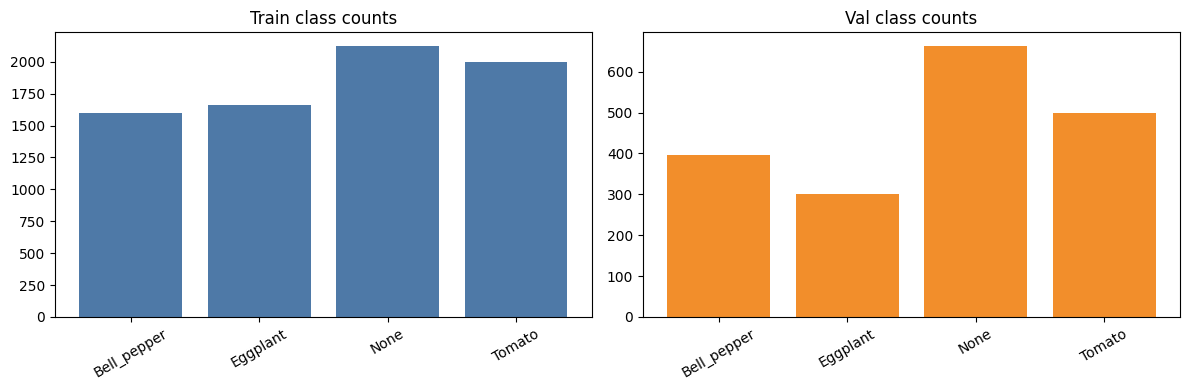

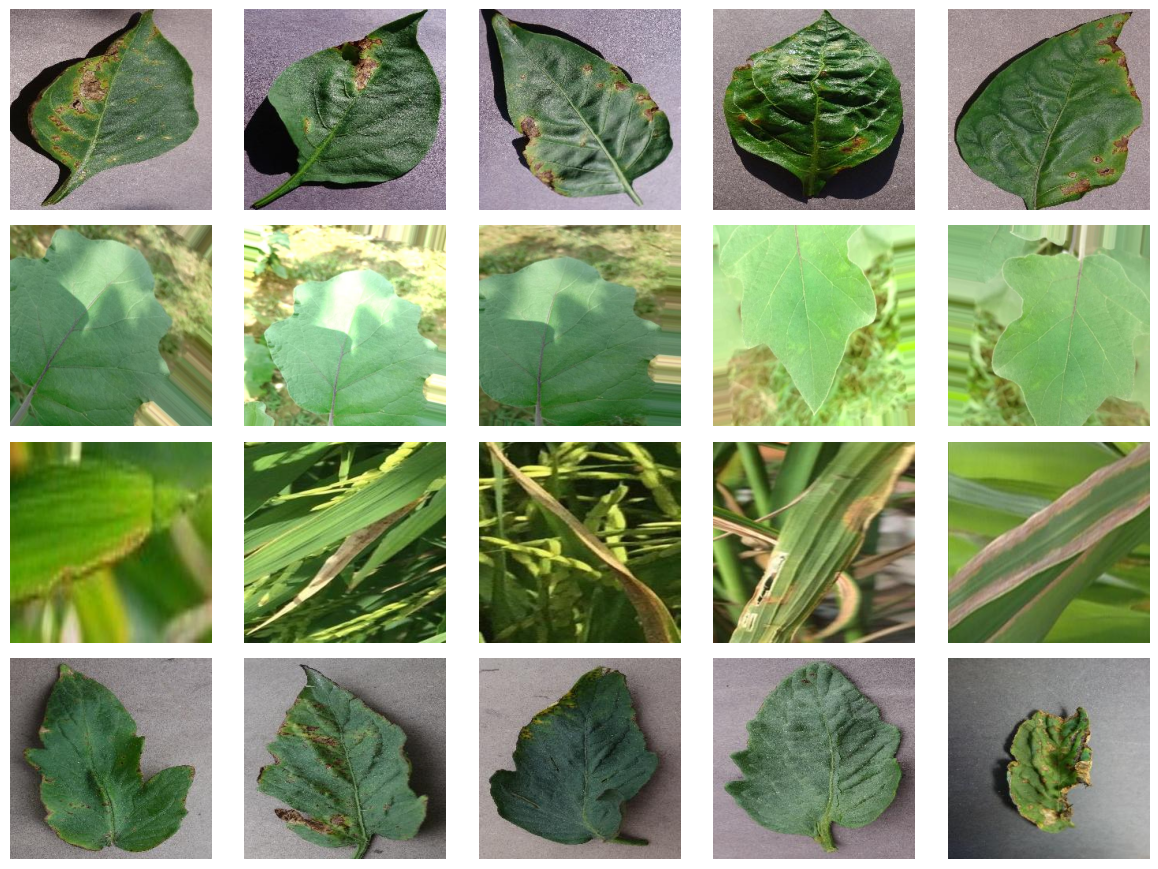

In [5]:
# Visualize class distribution and sample grid (before transforms)
from collections import Counter

# Class distribution
train_counts = Counter([label_names[i] for i in raw_ds["train"]["label"]])
val_counts = Counter([label_names[i] for i in raw_ds["val"]["label"]])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(train_counts.keys(), train_counts.values(), color="#4e79a7")
axes[0].set_title("Train class counts")
axes[0].tick_params(axis='x', rotation=30)
axes[1].bar(val_counts.keys(), val_counts.values(), color="#f28e2b")
axes[1].set_title("Val class counts")
axes[1].tick_params(axis='x', rotation=30)
plt.tight_layout()
plt.show()

# Sample grid (up to 5 per class)
fig, axes = plt.subplots(len(label_names), 5, figsize=(12, 2.2 * len(label_names)))
for class_idx, class_name in enumerate(label_names):
    # find indices in train set with this label
    idxs = [i for i, y in enumerate(raw_ds["train"]["label"]) if y == class_idx][:5]
    for j, idx in enumerate(idxs):
        img = raw_ds["train"][idx]["image"]
        axes[class_idx, j].imshow(img)
        axes[class_idx, j].axis("off")
        if j == 0:
            axes[class_idx, j].set_ylabel(class_name)
    for j in range(len(idxs), 5):
        axes[class_idx, j].axis("off")
plt.tight_layout()
plt.show()


In [6]:
import torchvision.transforms as T

processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

# Safe access helpers across processor versions
def _get_proc_attr(proc, name, default=None):
    if hasattr(proc, name):
        return getattr(proc, name)
    inner = getattr(proc, "image_processor", None)
    if inner is not None and hasattr(inner, name):
        return getattr(inner, name)
    return default

# Determine target image size
size_cfg = _get_proc_attr(processor, "size", {})
if isinstance(size_cfg, dict):
    if "height" in size_cfg and "width" in size_cfg:
        image_size = size_cfg["height"]
    elif "shortest_edge" in size_cfg:
        image_size = size_cfg["shortest_edge"]
    else:
        image_size = 256
else:
    image_size = int(size_cfg) if size_cfg is not None else 256

# Mean/std with fallback to ImageNet
mean = _get_proc_attr(processor, "image_mean", [0.485, 0.456, 0.406])
std = _get_proc_attr(processor, "image_std", [0.229, 0.224, 0.225])

train_transform = T.Compose([
    T.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

val_transform = T.Compose([
    T.Resize(int(image_size * 1.14)),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])


def make_transform_fn(is_train: bool):
    transform = train_transform if is_train else val_transform

    def _transform(examples: Dict[str, Any]) -> Dict[str, Any]:
        images = [transform(img.convert("RGB")) for img in examples["image"]]
        return {
            "pixel_values": images,
            "labels": examples["label"],
        }

    return _transform

raw_ds["train"].set_transform(make_transform_fn(is_train=True))
raw_ds["val"].set_transform(make_transform_fn(is_train=False))

print("Transforms ready. Image size:", image_size)
print("Normalize mean/std:", mean, std)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Transforms ready. Image size: 288
Normalize mean/std: [0.485, 0.456, 0.406] [0.229, 0.224, 0.225]


In [7]:
model = MobileViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_names),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

print(model.config)


Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at apple/mobilevit-small and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 640]) in the checkpoint and torch.Size([4, 640]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MobileViTConfig {
  "architectures": [
    "MobileViTForImageClassification"
  ],
  "aspp_dropout_prob": 0.1,
  "aspp_out_channels": 256,
  "atrous_rates": [
    6,
    12,
    18
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout_prob": 0.1,
  "conv_kernel_size": 3,
  "dtype": "float32",
  "expand_ratio": 4.0,
  "hidden_act": "silu",
  "hidden_dropout_prob": 0.1,
  "hidden_sizes": [
    144,
    192,
    240
  ],
  "id2label": {
    "0": "Bell_pepper",
    "1": "Eggplant",
    "2": "None",
    "3": "Tomato"
  },
  "image_size": 256,
  "initializer_range": 0.02,
  "label2id": {
    "Bell_pepper": 0,
    "Eggplant": 1,
    "None": 2,
    "Tomato": 3
  },
  "layer_norm_eps": 1e-05,
  "mlp_ratio": 2.0,
  "model_type": "mobilevit",
  "neck_hidden_sizes": [
    16,
    32,
    64,
    96,
    128,
    160,
    640
  ],
  "num_attention_heads": 4,
  "num_channels": 3,
  "output_stride": 32,
  "patch_size": 2,
  "qkv_bias": true,
  "semantic_loss_ignore_index": 255,
  "transfor

In [8]:
acc_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
from transformers import TrainerCallback
import torch

# Force CPU
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)
model.to(device)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    results = {
        "accuracy": acc_metric.compute(predictions=preds, references=labels)["accuracy"],
        "f1_weighted": f1_metric.compute(predictions=preds, references=labels, average="weighted")[
            "f1"
        ],
    }
    return results

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=5e-5,
    weight_decay=0.05,
    warmup_ratio=0.1,
    logging_strategy="steps",
    logging_steps=100,
    load_best_model_at_end=False,
    report_to=["none"],
    fp16=False,
    remove_unused_columns=False,
)

class PrintLossCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return
        if "loss" in logs and state.global_step > 0 and state.global_step % 100 == 0:
            print(f"step {state.global_step}: loss={logs['loss']:.4f}")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=raw_ds["train"],
    eval_dataset=raw_ds["val"],
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

trainer.add_callback(PrintLossCallback())

train_result = trainer.train()
print(train_result)

# Save model and processor
save_dir = OUTPUT_DIR
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)

print(f"Saved to: {save_dir}")


Using device: mps


/var/folders/lj/7vfh3pz11ng7wttzhzn9h3cw0000gn/T/ipykernel_51214/2502875167.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/shreeganeshnayak/Github-projects/AI-Powered-Multi-Crop-Pesticide-Recommendation-System/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,1.338000
200,1.008100
300,0.411300
400,0.170000
500,0.111400
600,0.089700
700,0.073000
800,0.071700
900,0.039900
1000,0.057100


step 100: loss=1.3380
step 200: loss=1.0081
step 300: loss=0.4113
step 400: loss=0.1700
step 500: loss=0.1114
step 600: loss=0.0897
step 700: loss=0.0730
step 800: loss=0.0717
step 900: loss=0.0399


/Users/shreeganeshnayak/Github-projects/AI-Powered-Multi-Crop-Pesticide-Recommendation-System/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


step 1000: loss=0.0571
step 1100: loss=0.0310
step 1200: loss=0.0428
step 1300: loss=0.0281


/Users/shreeganeshnayak/Github-projects/AI-Powered-Multi-Crop-Pesticide-Recommendation-System/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


step 1400: loss=0.0373
step 1500: loss=0.0248
step 1600: loss=0.0382
step 1700: loss=0.0330
step 1800: loss=0.0327


/Users/shreeganeshnayak/Github-projects/AI-Powered-Multi-Crop-Pesticide-Recommendation-System/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


step 1900: loss=0.0276
step 2000: loss=0.0375
step 2100: loss=0.0372
step 2200: loss=0.0230
step 2300: loss=0.0180
TrainOutput(global_step=2310, training_loss=0.1637657520381403, metrics={'train_runtime': 13854.4255, 'train_samples_per_second': 2.667, 'train_steps_per_second': 0.167, 'total_flos': 2.7249424291713024e+17, 'train_loss': 0.1637657520381403, 'epoch': 5.0})
Saved to: /Users/shreeganeshnayak/Github-projects/AI-Powered-Multi-Crop-Pesticide-Recommendation-System/models/mobilevit-small-finetuned-vegetables


In [9]:
metrics = trainer.evaluate(eval_dataset=raw_ds["val"])  # uses best model if load_best_model_at_end=True
print("Validation metrics:", metrics)


/Users/shreeganeshnayak/Github-projects/AI-Powered-Multi-Crop-Pesticide-Recommendation-System/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation metrics: {'eval_loss': 0.0009903168538585305, 'eval_accuracy': 1.0, 'eval_f1_weighted': 1.0, 'eval_runtime': 23.432, 'eval_samples_per_second': 79.379, 'eval_steps_per_second': 4.993, 'epoch': 5.0}


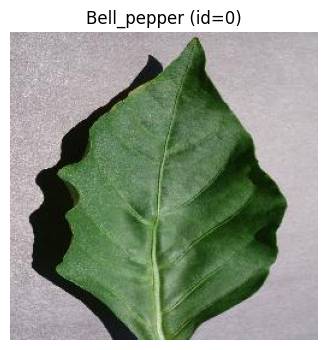

Index: 1143
Label id/name: 0 Bell_pepper
Path: /Users/shreeganeshnayak/Github-projects/AI-Powered-Multi-Crop-Pesticide-Recommendation-System/data/vegetables/train/Bell_pepper/Pepper__bell___healthy/7541f271-f44a-4c7c-9602-b64149e9fa2a___JR_HL 7571.JPG


In [18]:
# Show one random image with its 4-class label
import random
import matplotlib.pyplot as plt

# Load a fresh dataset view without transforms for visualization
raw_ds_viz = load_dataset("imagefolder", data_dir=TRAIN_DIR, split="train", drop_labels=True)
raw_ds_viz = raw_ds_viz.map(
    assign_superclass, batched=True, fn_kwargs={"split_root": TRAIN_DIR}
)
class_feature = ClassLabel(names=SUPERCLASSES)
raw_ds_viz = raw_ds_viz.cast_column("label", class_feature)

# Pick a random example
idx = random.randrange(len(raw_ds_viz))
example = raw_ds_viz[idx]
img = example["image"]
label_id = int(example["label"])
label_name = id2label[label_id]

# Visualize
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis("off")
plt.title(f"{label_name} (id={label_id})")
plt.show()

print("Index:", idx)
print("Label id/name:", label_id, label_name)
print("Path:", getattr(img, "filename", "N/A"))

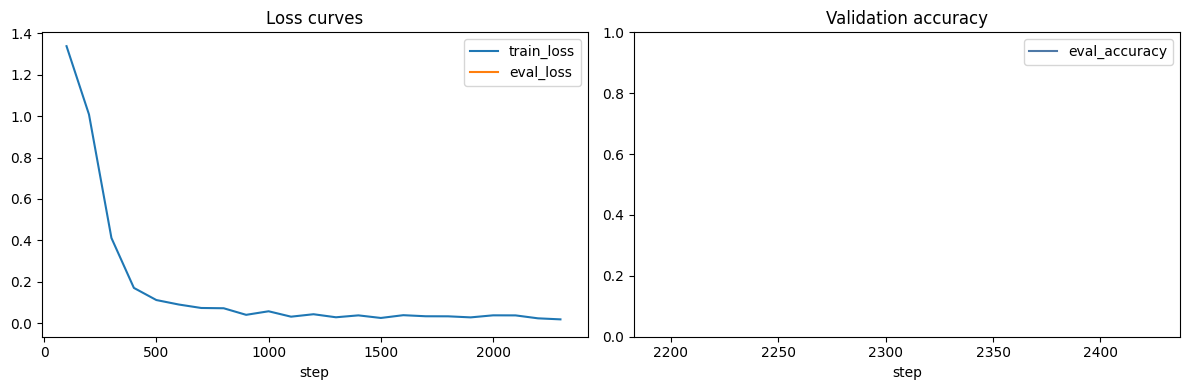

In [19]:
# Plot training curves from Trainer log history
hist = trainer.state.log_history

# Extract lists
steps, train_loss = [], []
val_steps, eval_loss, eval_acc = [], [], []
for entry in hist:
    if "loss" in entry and "epoch" in entry and "learning_rate" in entry:
        steps.append(entry.get("step", len(steps)))
        train_loss.append(entry["loss"])
    if "eval_loss" in entry:
        val_steps.append(entry.get("step", len(val_steps)))
        eval_loss.append(entry["eval_loss"])
        if "eval_accuracy" in entry:
            eval_acc.append(entry["eval_accuracy"])

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(steps, train_loss, label="train_loss")
if eval_loss:
    axes[0].plot(val_steps, eval_loss, label="eval_loss")
axes[0].set_title("Loss curves")
axes[0].set_xlabel("step")
axes[0].legend()

if eval_acc:
    axes[1].plot(val_steps[: len(eval_acc)], eval_acc, label="eval_accuracy", color="#4e79a7")
    axes[1].set_title("Validation accuracy")
    axes[1].set_xlabel("step")
    axes[1].set_ylim(0, 1)
    axes[1].legend()
else:
    axes[1].axis("off")
plt.tight_layout()
plt.show()


In [20]:
# Inspect image shapes: raw (PIL) vs transformed tensor
from itertools import islice

def show_shapes(split: str = "train", num_samples: int = 5):
    ds = raw_ds[split]
    print(f"Split: {split}")
    for i in range(min(num_samples, len(ds))):
        ex = ds[i]
        pil_img = ex["image"]  # PIL.Image
        w, h = pil_img.size
        # Apply corresponding transform to get tensor shape
        if split == "train":
            tensor = train_transform(pil_img.convert("RGB"))
        else:
            tensor = val_transform(pil_img.convert("RGB"))
        c, th, tw = tensor.shape
        print(f"idx={i}: PIL (W,H)=({w},{h}) | tensor (C,H,W)=({c},{th},{tw})")

show_shapes("train", num_samples=5)
show_shapes("val", num_samples=5)


Split: train


TypeError: 'NoneType' object is not callable

In [ ]:
# Save model and processor
save_dir = OUTPUT_DIR
model.save_pretrained(save_dir)
processor.save_pretrained(save_dir)

print(f"Saved to: {save_dir}")


In [9]:
# Audit: verify how many samples are seen per epoch by the training dataloader
from math import ceil

train_count_reported = len(raw_ds["train"])
train_dl = trainer.get_train_dataloader()
num_batches = len(train_dl)

seen = 0
for batch in train_dl:
    # 'labels' is a tensor of shape (batch_size,)
    seen += int(batch["labels"].shape[0])

print(f"Reported train samples: {train_count_reported}")
print(f"Batches per epoch: {num_batches}")
print(f"Samples iterated this epoch: {seen}")
print(f"Batch size (approx): {ceil(seen / max(1, num_batches))}")

if seen != train_count_reported:
    print("Warning: Dataloader seen count != dataset size (drop_last? filtering? transforms?).")
else:
    print("OK: All training samples are being iterated in an epoch.")


Reported train samples: 7389
Batches per epoch: 462
Samples iterated this epoch: 7389
Batch size (approx): 16
OK: All training samples are being iterated in an epoch.


In [14]:
# Debug: inspect one training batch and compute loss manually
import torch

train_dl = trainer.get_train_dataloader()
batch = next(iter(train_dl))

pv = batch["pixel_values"].to(device)
lb = batch["labels"].to(device)
print("pixel_values:", pv.dtype, pv.shape, "mean=", float(pv.mean()), "std=", float(pv.std()))
print("labels:", lb.dtype, lb.shape, "min=", int(lb.min()), "max=", int(lb.max()), "unique=", torch.unique(lb).tolist())

model.train()
with torch.enable_grad():
    out = model(pixel_values=pv, labels=lb)
    loss_val = float(out.loss.detach().cpu())
    logits = out.logits.detach().cpu()

print("Manual forward loss:", loss_val)
print("logits stats: min=", float(logits.min()), "max=", float(logits.max()), "mean=", float(logits.mean()))


pixel_values: torch.float32 torch.Size([16, 3, 288, 288]) mean= -0.13472087681293488 std= 0.8683067560195923
labels: torch.int64 torch.Size([16]) min= 0 max= 3 unique= [0, 1, 2, 3]
Manual forward loss: nan
logits stats: min= nan max= nan mean= nan
